# Traditional approach: Use Scikit learn or XGBoost directly on Notebook
---

Outside of **SageMaker**, normally data scientists will spin up their environment (either via IDE, or server) and create new notebook (or *py* file).

This notebook is used to demonstrate that it can work the same way as traditional way to develop the ML model. I will build out 2 ML models based on;

- scikit library
- XGboost library

## About dataset...
---

In this notebook demonstration, we will be using **Auto Insurance** claim data, with 100k observations. The data is provided and is kept in `../data/` folder.


<div class="alert alert-block alert-info">
    <b>Note</b>: This notebook is tested on <b>ml.m5.xlarge</b> instance with <i>Data Science 3.0</i> image.
</div>

## Set up
---

**xgboost** didn't come directly with **Data Science 3.0** image 

Note if you are using other image like *Base Python*, you will need to install scikit-learn as well.

In [2]:
%pip install xgboost --quiet --root-user-action=ignore

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)

## Explore dataset
---

As part of any data science project, I will load the dataset and basically create basic feature engineers and visualize the dataset for better understanding.

In [4]:
df = pd.read_csv('../data/Insurance_FraudulentAutoInsuranceClaims_100k.csv')
print(df.shape)
display(df.head(3))

(100000, 23)


,first_name,last_name,date_of_birth,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,EVENT_LABEL,EVENT_TIMESTAMP,EVENT_ID,ENTITY_TYPE,ENTITY_ID,policy_id,incident_type,LABEL_TIMESTAMP
0,Jose,Haynes,1927-10-16,5.0,2.0,2.0,1.0,0.0,12986.0,4375.0,15.0,43.0,666.0,2995.0,5.0,legit,2022-07-13T10:03:22Z,b4b09066-de78-40d9-bb54-498fee1770c5,customer,a612-85445302,b4b09066-de78-40d9-bb54-498fee1770c5,collision,2023-03-06T15:05:50Z
1,Vicki,Stark,1952-09-20,4.0,3.0,5.0,2.0,0.0,6065.0,5941.0,10.0,45.0,649.0,1535.0,4.0,legit,2023-02-03T02:48:21Z,d2ccfe0a-e65b-4983-bbd8-de73506f0bca,customer,c786-86718442,d2ccfe0a-e65b-4983-bbd8-de73506f0bca,theft,2023-03-06T15:05:50Z
2,Breanna,Kline,1984-05-14,4.0,3.0,3.0,2.0,0.0,12017.0,4712.0,22.0,30.0,436.0,3043.0,5.0,legit,2022-11-19T03:22:35Z,cd4084d4-717d-456b-baa9-bae079f80aaf,customer,b340-10389704,cd4084d4-717d-456b-baa9-bae079f80aaf,collision,2023-03-06T15:05:50Z


- Column `EVENT_LABEL` is the target variable.
- Columns like `LABEL_TIMESTAMP`, `ENTITY_TYPE` has only 1 value, which can be dropped.
- In this case, `policy_id` is unique across all columns, this is initially kept for reference purpose.
- Columns `EVENT_TIMESTAMP`, `ENTITY_ID`, `EVENT_ID` are specific for Amazon Fraud Detector services, they will be dropped.
- column `EVENT_TIMESTAMP` however can be used with `date_of_birth` column to create new feature named **age**.

In [5]:
df.loc[:, 'EVENT_TIMESTAMP'] = pd.to_datetime(pd.to_datetime(df['EVENT_TIMESTAMP']).dt.strftime('%Y-%m-%d'))
df.loc[:, 'date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df.loc[:, 'age'] = df['EVENT_TIMESTAMP'].apply(lambda x: x.year) - df['date_of_birth'].apply(lambda x: x.year)

In [6]:
df.drop(['LABEL_TIMESTAMP', 'ENTITY_TYPE'], axis=1, inplace=True)
df.drop(['EVENT_TIMESTAMP', 'ENTITY_ID', 'EVENT_ID'], axis=1, inplace=True)

- With this `date_of_birth` column can be dropped as well
- `first_name` and `last_name` do not provide any information as well as these are merely **PII** data, which should not be used in model building.

In [7]:
df.drop(['date_of_birth', 'first_name', 'last_name'], axis=1, inplace=True)

In [8]:
print(df.shape)
display(df.head(3))

(100000, 16)


,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,EVENT_LABEL,policy_id,incident_type,age
0,5.0,2.0,2.0,1.0,0.0,12986.0,4375.0,15.0,43.0,666.0,2995.0,5.0,legit,b4b09066-de78-40d9-bb54-498fee1770c5,collision,95
1,4.0,3.0,5.0,2.0,0.0,6065.0,5941.0,10.0,45.0,649.0,1535.0,4.0,legit,d2ccfe0a-e65b-4983-bbd8-de73506f0bca,theft,71
2,4.0,3.0,3.0,2.0,0.0,12017.0,4712.0,22.0,30.0,436.0,3043.0,5.0,legit,cd4084d4-717d-456b-baa9-bae079f80aaf,collision,38


### Quick EDA
---

Let's do a quick plot on dataset.

In [9]:
target_col = 'EVENT_LABEL'

print(df[target_col].value_counts(normalize=True) * 100)

legit    94.955
fraud     5.045
Name: EVENT_LABEL, dtype: float64


In [10]:
sns.set_theme(
    context='notebook', style="whitegrid", palette='Spectral'
)

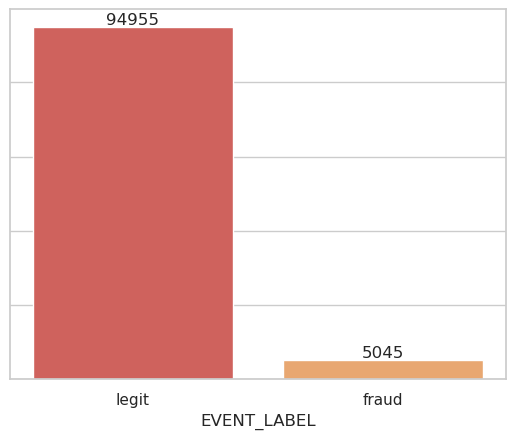

In [11]:
ax = sns.countplot(data=df, x=target_col)
ax.bar_label(ax.containers[0])
ax.tick_params(left=False, bottom=False)
ax.set(ylabel=None, yticklabels=[])
plt.plot();

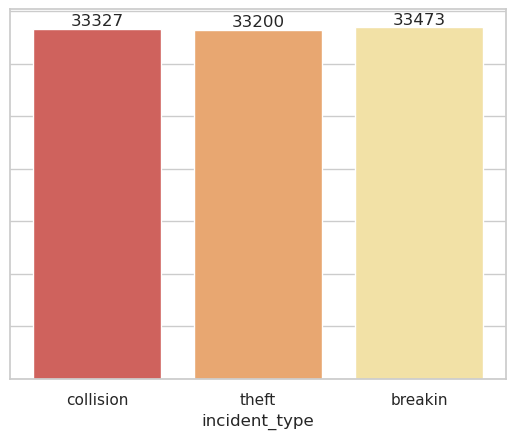

In [12]:
ax = sns.countplot(data=df, x='incident_type')
ax.bar_label(ax.containers[0])
ax.tick_params(left=False, bottom=False)
ax.set(ylabel=None, yticklabels=[])
plt.plot();

In [13]:
num_col_list = df.select_dtypes(exclude=['object']).columns

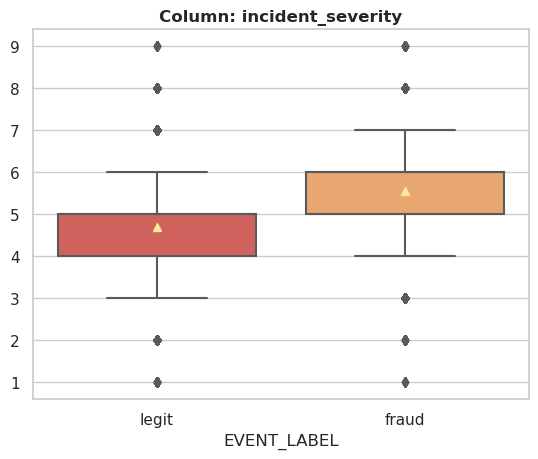

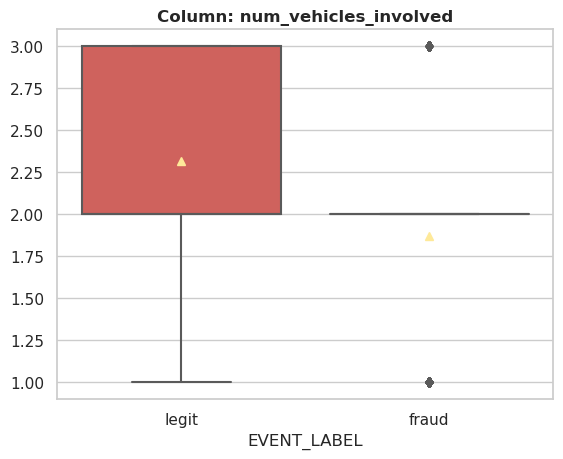

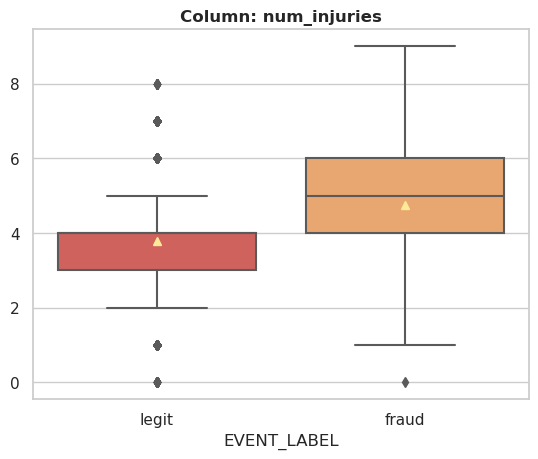

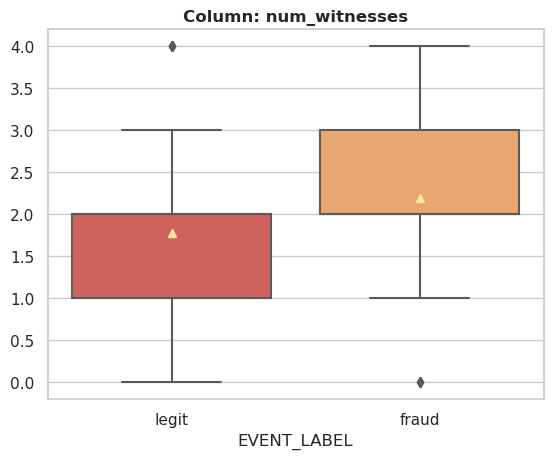

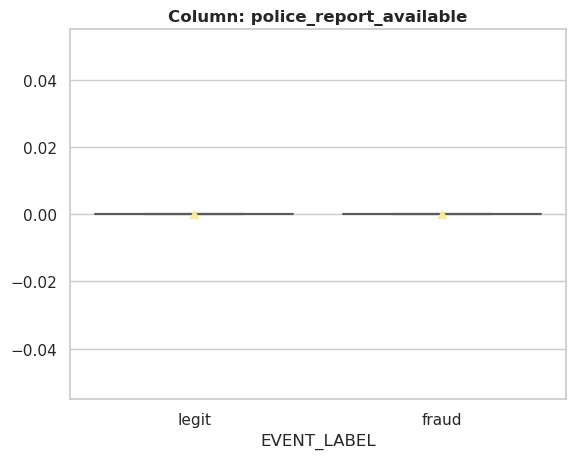

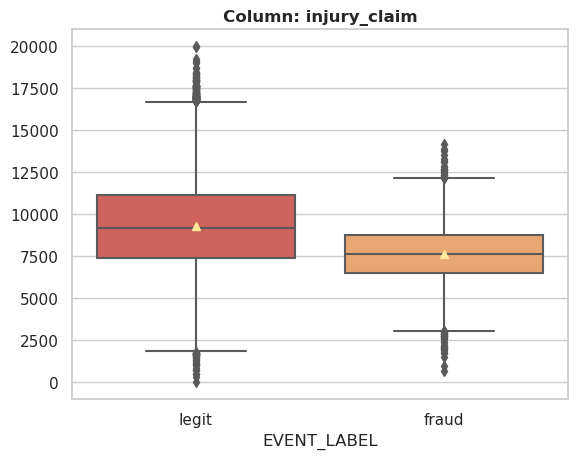

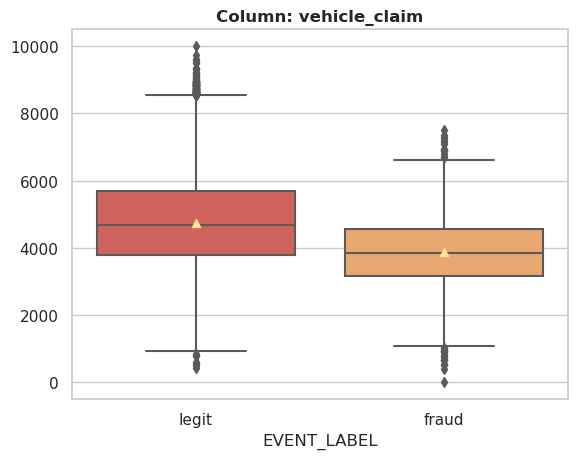

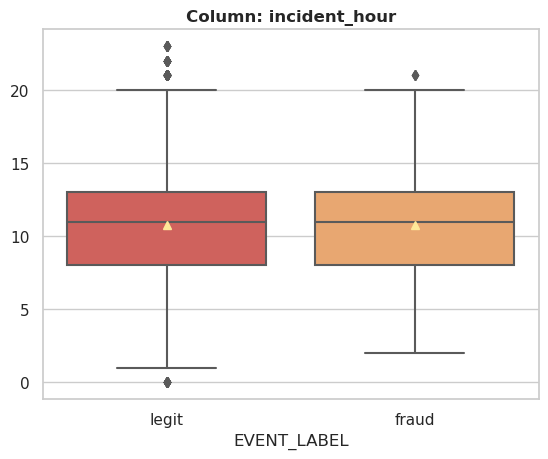

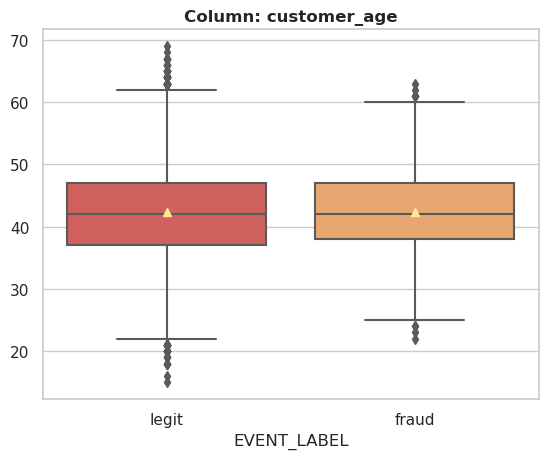

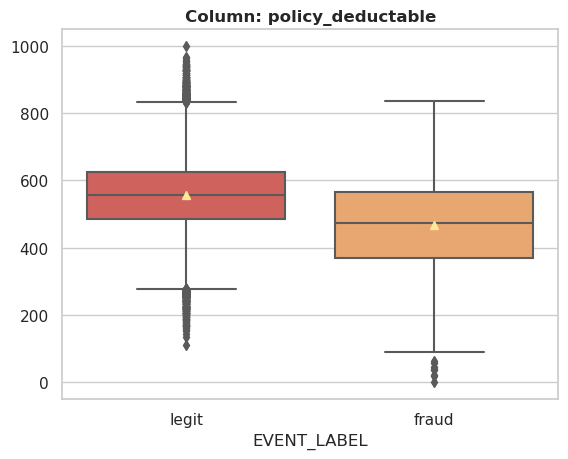

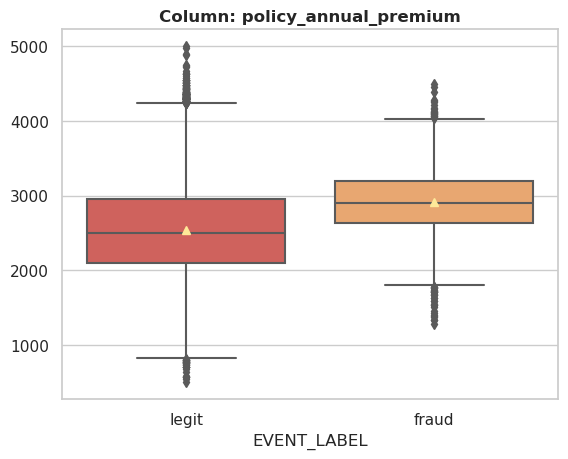

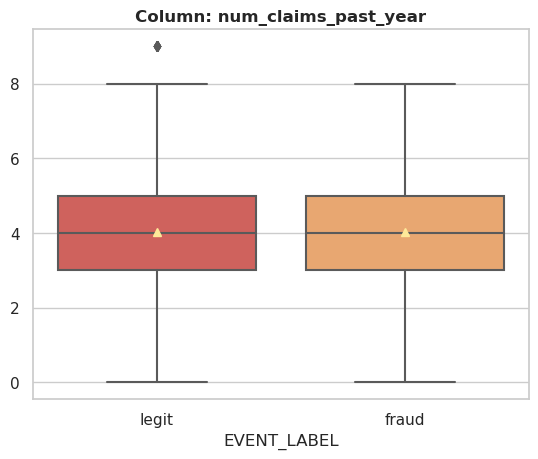

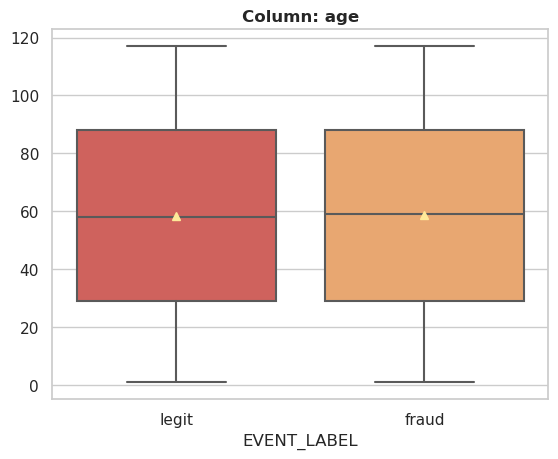

In [14]:
for num_col in num_col_list:
    ax = sns.boxplot(data=df, x=target_col, y=num_col, showmeans=True)
    ax.set_title(f'Column: {num_col}', weight='bold')
    ax.set(ylabel=None)
    ax.tick_params(left=False, bottom=False)
    plt.show();

Check null value

In [15]:
df.isnull().sum()

incident_severity          0
num_vehicles_involved      0
num_injuries               0
num_witnesses              0
police_report_available    0
injury_claim               0
vehicle_claim              0
incident_hour              0
customer_age               0
policy_deductable          0
policy_annual_premium      0
num_claims_past_year       0
EVENT_LABEL                0
policy_id                  0
incident_type              0
age                        0
dtype: int64

- Convert string to numeric for target variable
- Create dummy variables for string or object column

In [16]:
df['is_fraud'] = df[target_col].map({'fraud': 1, 'legit': 0})
df.drop([target_col], axis=1, inplace=True)
target_col = 'is_fraud' 

In [17]:
_tmp = pd.get_dummies(df['incident_type'], drop_first=True, dtype='int')
full_df = pd.concat([df.drop(['policy_id', 'incident_type'], axis=1), _tmp], axis=1)

In [18]:
full_df.head()

,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,age,is_fraud,collision,theft
0,5.0,2.0,2.0,1.0,0.0,12986.0,4375.0,15.0,43.0,666.0,2995.0,5.0,95,0,1,0
1,4.0,3.0,5.0,2.0,0.0,6065.0,5941.0,10.0,45.0,649.0,1535.0,4.0,71,0,0,1
2,4.0,3.0,3.0,2.0,0.0,12017.0,4712.0,22.0,30.0,436.0,3043.0,5.0,38,0,1,0
3,5.0,2.0,3.0,2.0,0.0,10015.0,4120.0,13.0,41.0,640.0,3197.0,4.0,82,0,1,0
4,5.0,2.0,1.0,1.0,0.0,10962.0,3255.0,14.0,46.0,593.0,3738.0,3.0,4,0,1,0


## Split Data set
---

In this step, I will split the full dataset onto train, validation, and test datasets.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
X_df = full_df.drop([target_col], axis=1)
y_df = full_df[target_col]
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in train_test_split.split(X_df, y_df):
    train_df = full_df.loc[train_idx]
    test_df = full_df.loc[test_idx]

    
X_train_df = train_df.drop([target_col], axis=1)
y_train_df = train_df[target_col]
train_val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in train_val_split.split(X_train_df, y_train_df):
    train_df = full_df.loc[train_idx]
    val_df = full_df.loc[val_idx]
    
print(train_df.shape, val_df.shape, test_df.shape)

(64000, 16) (16000, 16) (20000, 16)


Note: we can apply more statistical method and feature engineering. However, this is to demonstrate the capability and not focusing on model performance.

## Model building
---

For demonstration, several algorithms within **sklearn** library are used as well as popular algorithm, **xgboost**.

In [21]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost

# Metrics
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

In [22]:
from typing import Tuple

def split_x_y(df: pd.DataFrame, target_col: str=target_col) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = df.drop([target_col], axis=1)
    y = df.loc[:, target_col]
    return X, y


X_train, y_train = split_x_y(train_df)
X_val, y_val = split_x_y(val_df)
X_test, y_test = split_x_y(test_df)


### Logistic Regression

In [23]:
log_reg = LogisticRegression(random_state=42, verbose=1)
log_reg.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43614D+04    |proj g|=  2.69868D+08


 This problem is unconstrained.



At iterate   50    f=  8.80573D+03    |proj g|=  9.72456D+03

At iterate  100    f=  7.49405D+03    |proj g|=  2.75896D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    118      1     0     0   2.759D+05   7.494D+03
  F =   7494.0484108700384     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42, verbose=1)

In [24]:
y_pred_val = log_reg.predict(X_val)
y_prob_val = log_reg.predict_proba(X_val)

print(
    y_pred_val[:5],
    y_prob_val[:5]
)

[0 0 0 0 0] [[9.93000948e-01 6.99905157e-03]
 [9.92285528e-01 7.71447171e-03]
 [9.99340576e-01 6.59423524e-04]
 [8.77820763e-01 1.22179237e-01]
 [9.97870879e-01 2.12912071e-03]]


In [25]:
model_eval = {
    'model': [],
    'roc_auc_score': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

def add_model_eval(model, roc_auc_score, precision, recall, f1_score):
    model_eval['model'].append(model)
    model_eval['roc_auc_score'].append(f'{roc_auc_score: .4f}')
    model_eval['precision'].append(f'{precision: .4f}')
    model_eval['recall'].append(f'{recall: .4f}')
    model_eval['f1_score'].append(f'{f1_score: .4f}')
    return model_eval
    
def view_models_eval(model_eval: dict=model_eval, sort:bool =False):
    eval_df = pd.DataFrame(model_eval)
    
    if sort:
        eval_df = eval_df.sort_values(by=['recall', 'f1_score'], ascending=[False, False])
    
    display(eval_df)
    return eval_df

In [26]:
add_model_eval(
    'Logistic regression', 
    roc_auc_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val), 
    f1_score(y_val, y_pred_val)
)
eval_df = view_models_eval(model_eval)

,model,roc_auc_score,precision,recall,f1_score
0,Logistic regression,0.6764,0.7313,0.3599,0.4824


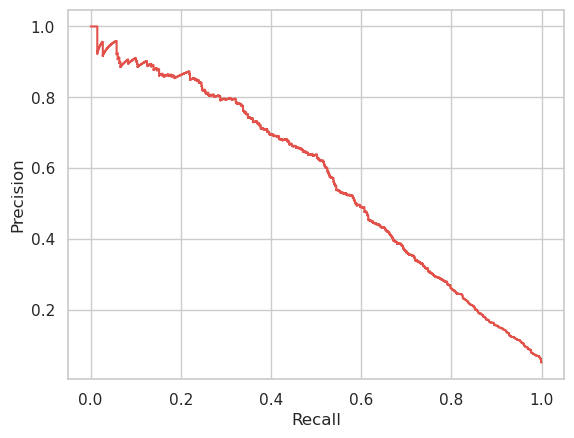

In [27]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(
    y_val, 
    log_reg.decision_function(X_val), 
    pos_label=log_reg.classes_[1]
)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

### Stochastic Gradient Descent (SGD) Classifier

In [28]:
sgd_clf = SGDClassifier(random_state=42, verbose=0)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [29]:
y_pred_val = sgd_clf.predict(X_val)

print(
    y_pred_val[:5]
)

[0 0 0 0 0]


In [30]:
add_model_eval(
    'SGD Classifier', 
    roc_auc_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val), 
    f1_score(y_val, y_pred_val)
)

eval_df = view_models_eval()

,model,roc_auc_score,precision,recall,f1_score
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800


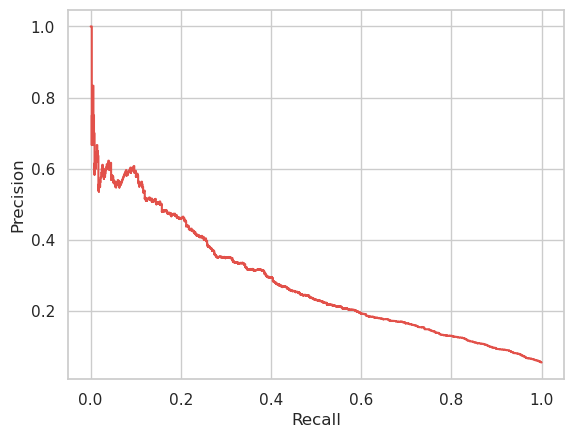

In [31]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(
    y_val, 
    sgd_clf.decision_function(X_val), 
    pos_label=sgd_clf.classes_[1]
)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

### Random Forest Classifier

In [32]:
forest_clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [33]:
y_pred_val = forest_clf.predict(X_val)
y_prob_val = forest_clf.predict_proba(X_val)

print(
    y_pred_val[:5],
    y_prob_val[:5]
)

[0 0 0 0 0] [[1.   0.  ]
 [0.97 0.03]
 [0.98 0.02]
 [0.99 0.01]
 [1.   0.  ]]


In [34]:
add_model_eval(
    'Random Forest', 
    roc_auc_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val), 
    f1_score(y_val, y_pred_val)
)

eval_df = view_models_eval()

,model,roc_auc_score,precision,recall,f1_score
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800
2,Random Forest,0.8991,0.9761,0.7993,0.8789


### Support Vector Machine Classifier

In [35]:
svm_clf = SVC(random_state=42, verbose=0)
svm_clf.fit(X_train, y_train)

SVC(random_state=42, verbose=0)

In [36]:
y_pred_val = svm_clf.predict(X_val)

print(
    y_pred_val[:5]
)

[0 0 0 0 0]


In [37]:
add_model_eval(
    'SVC', 
    roc_auc_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val), 
    f1_score(y_val, y_pred_val)
)

eval_df = view_models_eval()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,roc_auc_score,precision,recall,f1_score
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800
2,Random Forest,0.8991,0.9761,0.7993,0.8789
3,SVC,0.5000,0.0000,0.0000,0.0000


### Naive Bayes

In [38]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB()

In [39]:
y_pred_val = nb_clf.predict(X_val)
y_prob_val = nb_clf.predict_proba(X_val)

print(
    y_pred_val[:5],
    y_prob_val[:5]
)

[0 0 0 0 0] [[9.52110323e-01 4.78896771e-02]
 [9.94205199e-01 5.79480064e-03]
 [9.99679602e-01 3.20398361e-04]
 [9.96127844e-01 3.87215616e-03]
 [9.99760047e-01 2.39952823e-04]]


In [40]:
add_model_eval(
    'Naive Bayes', 
    roc_auc_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val), 
    f1_score(y_val, y_pred_val)
)

eval_df = view_models_eval()

,model,roc_auc_score,precision,recall,f1_score
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800
2,Random Forest,0.8991,0.9761,0.7993,0.8789
3,SVC,0.5000,0.0000,0.0000,0.0000
4,Naive Bayes,0.7391,0.7439,0.4871,0.5888


In [41]:
eval_df.sort_values(by=['roc_auc_score'], ascending=False)

,model,roc_auc_score,precision,recall,f1_score
2,Random Forest,0.8991,0.9761,0.7993,0.8789
4,Naive Bayes,0.7391,0.7439,0.4871,0.5888
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800
3,SVC,0.5000,0.0000,0.0000,0.0000


### XGBoost

In [42]:
xgb_clf = xgboost.XGBClassifier(random_state=42, verbosity=0)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [43]:
y_pred_val = xgb_clf.predict(X_val)
y_prob_val = xgb_clf.predict_proba(X_val)

print(
    y_pred_val[:5],
    y_prob_val[:5]
)

[0 0 0 0 0] [[9.9992901e-01 7.0971539e-05]
 [9.9982566e-01 1.7435786e-04]
 [9.9995506e-01 4.4953966e-05]
 [9.9957716e-01 4.2281710e-04]
 [9.9989152e-01 1.0847044e-04]]


In [44]:
add_model_eval(
    'XGBoost', 
    roc_auc_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val), 
    f1_score(y_val, y_pred_val)
)

eval_df = view_models_eval()

,model,roc_auc_score,precision,recall,f1_score
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800
2,Random Forest,0.8991,0.9761,0.7993,0.8789
3,SVC,0.5000,0.0000,0.0000,0.0000
4,Naive Bayes,0.7391,0.7439,0.4871,0.5888
5,XGBoost,0.9435,0.9454,0.8898,0.9168


In [45]:
eval_df.sort_values(by=['roc_auc_score'], ascending=False)

,model,roc_auc_score,precision,recall,f1_score
5,XGBoost,0.9435,0.9454,0.8898,0.9168
2,Random Forest,0.8991,0.9761,0.7993,0.8789
4,Naive Bayes,0.7391,0.7439,0.4871,0.5888
0,Logistic regression,0.6764,0.7313,0.3599,0.4824
1,SGD Classifier,0.5207,0.6034,0.0428,0.0800
3,SVC,0.5000,0.0000,0.0000,0.0000


This marks the end of this demo notebook of using the notebook to train the model directly.